In [27]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df_btc = pd.read_csv(r'../data/cryptoInd/btc_ind.csv')

# Correltion Matrix

## Scaling

In [3]:
df_btc.set_index('Date', inplace=True)
scaled_df = df_btc.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_btc)
scaled_df = pd.DataFrame(scaled_feat, index = df_btc.index, columns=df_btc.columns)
scaled_df.head()

,adj_close,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,0.060647,0.060647,0.061653,0.062897,0.065224,0.000084,0.053696,0.000000,0.054771,0.516926,...,0.065440,0.545576,0.550672,0.573368,0.663954,0.078377,0.303097,0.354495,0.387218,0.135677
2017-11-10,0.052479,0.052479,0.051133,0.060838,0.060977,0.005783,0.054484,0.001074,0.054396,0.494300,...,0.064971,0.539145,0.549780,0.554294,0.536081,0.072923,0.269376,0.297351,0.382318,0.134771
2017-11-13,0.051567,0.051567,0.041753,0.053187,0.041762,0.008817,0.055788,0.003895,0.051783,0.394334,...,0.063023,0.518764,0.539132,0.517032,0.516691,0.058555,0.243613,0.131115,0.389603,0.135763
2017-11-14,0.052752,0.052752,0.051526,0.052481,0.051455,0.000000,0.056347,0.004934,0.051818,0.360307,...,0.062428,0.516624,0.535417,0.520817,0.528255,0.053491,0.430387,0.246444,0.345563,0.133431
2017-11-15,0.063321,0.063321,0.054265,0.061300,0.052594,0.002886,0.057283,0.006192,0.053258,0.338523,...,0.063221,0.520014,0.533217,0.538787,0.618543,0.053189,0.712852,0.457197,0.345761,0.127862


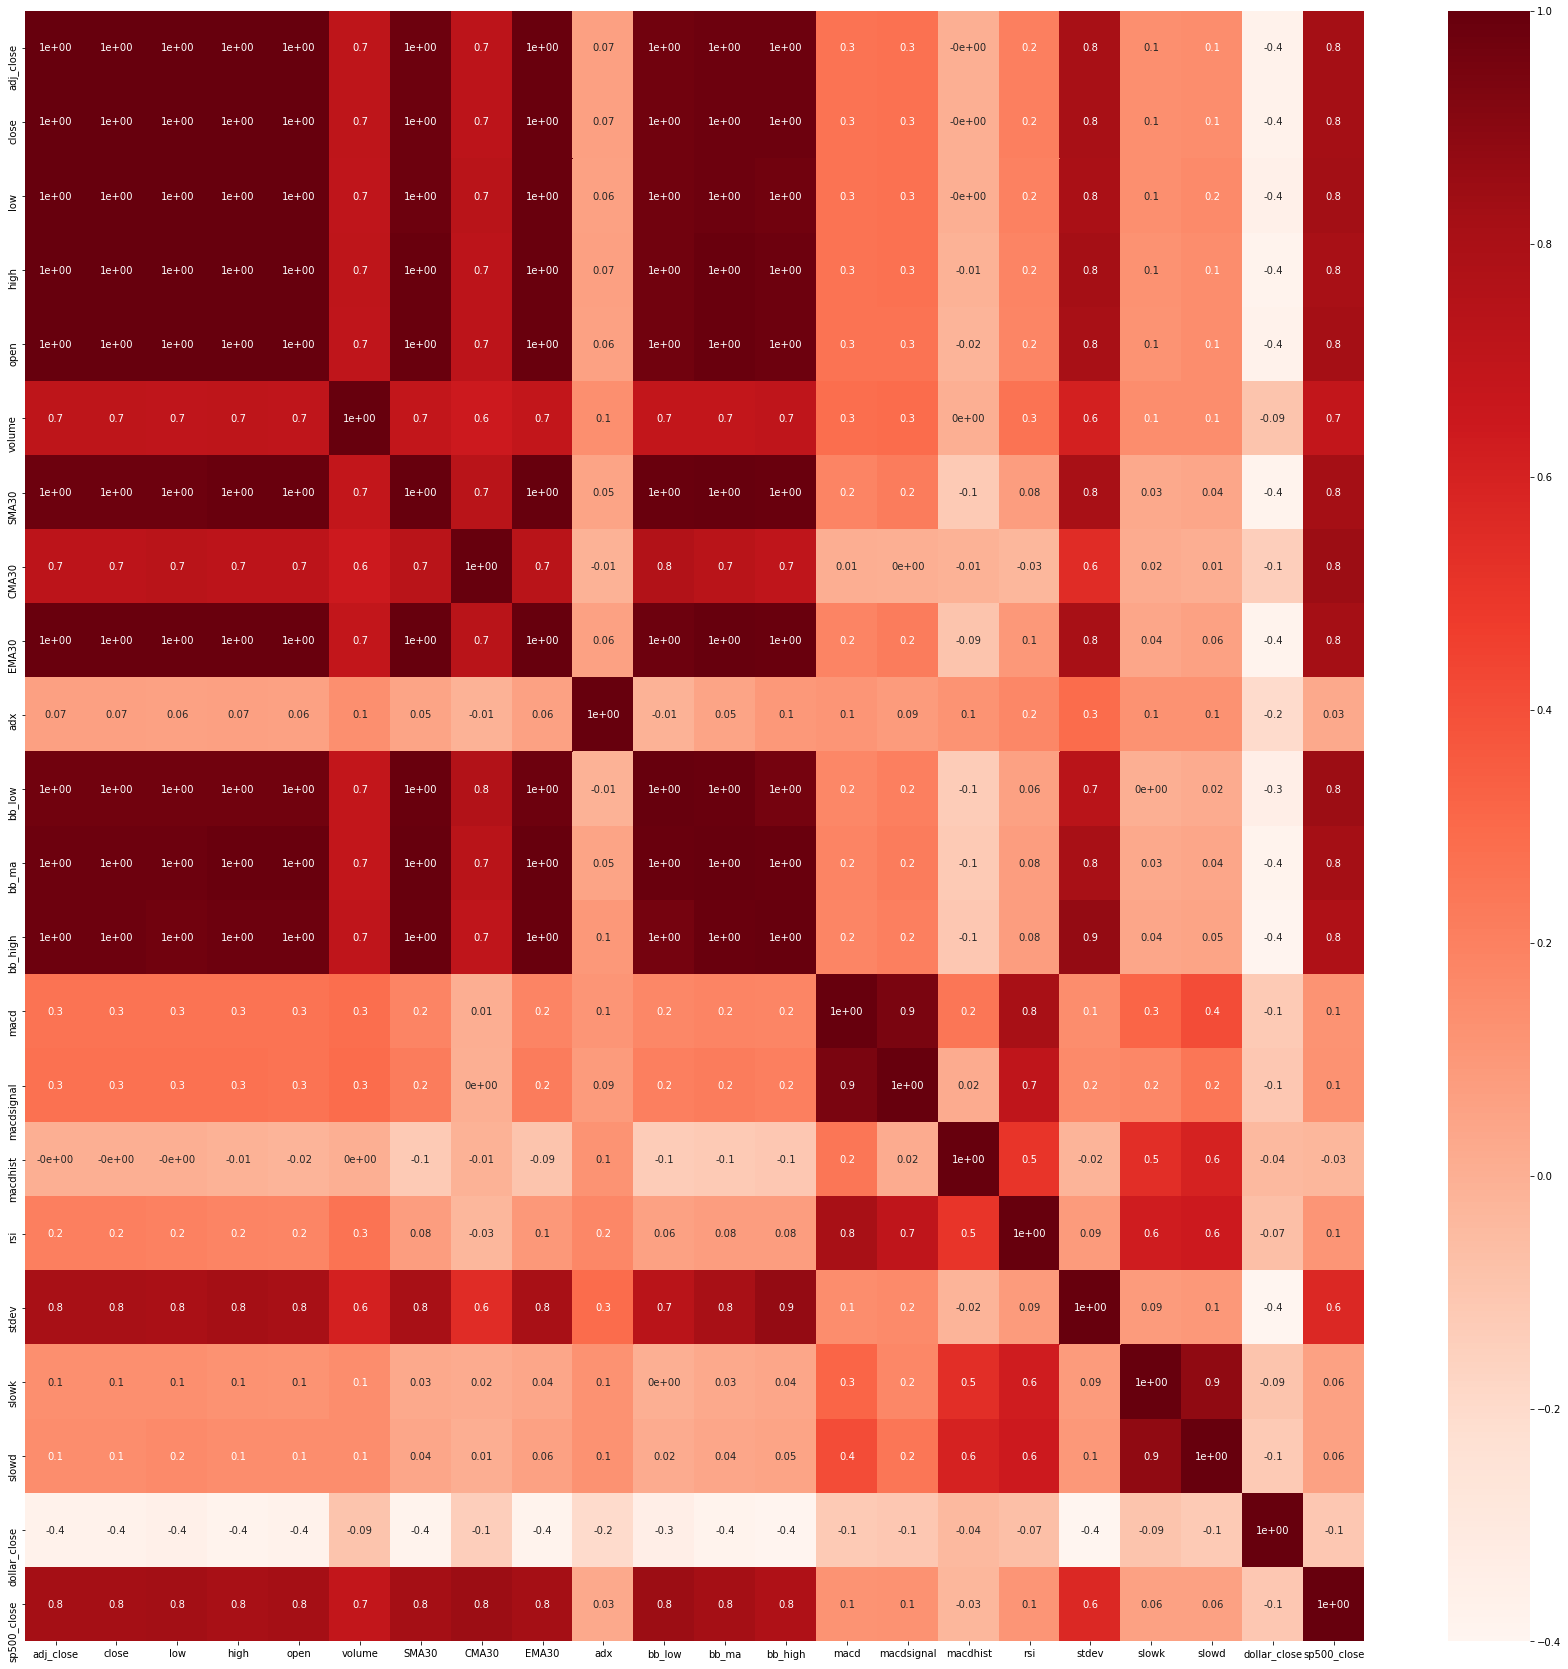

In [4]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [5]:
scaled_df.columns

Index(['adj_close', 'close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30',
       'EMA30', 'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal',
       'macdhist', 'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close',
       'sp500_close'],
      dtype='object')

In [6]:
scaled_df.drop(['low', 'high', 'open','SMA30','EMA30','bb_low',
 'bb_ma', 'bb_high', 'stdev', 'sp500_close'], axis=1, inplace=True)

## Hand-Made Sliding Window

In [7]:
df_btc.reset_index(inplace = True)
df_btc['Date'] = pd.to_datetime(df_btc['Date']).dt.date
y = df_btc.copy()
#y.reset_index(inplace=True)
X = scaled_df.drop(['close'], axis=1)
X.reset_index(inplace=True)
y['Date'] = pd.to_datetime(y['Date']).dt.date

In [8]:
def train_test_split_time_series(data, num_df, column_date):
    #data: data frame to split
    #num_df: number of differente splits
    #column_date: name of the column that has the Date info
    data[column_date] = pd.to_datetime(data[column_date]).dt.date
    date_split=[]
    max_date = data[column_date].max()
    min_date = data[column_date].min()
    range_date = max_date-min_date
    split_criteria = 0.2/(num_df-1)
    train = 0.6
    test = 0.8
    inicial = 0
    for i in range(num_df):
        list_to_add=[]
        list_to_add.append((min_date + range_date*inicial))
        list_to_add.append((min_date + range_date*train))
        list_to_add.append((min_date + range_date*test))
        train = train + split_criteria
        test = test + split_criteria
        inicial = inicial + split_criteria

        date_split.append(list_to_add)
    
    
    return date_split

In [9]:
date = train_test_split_time_series(X, num_df=3, column_date='Date')

In [10]:
train_1 = df_btc[(df_btc['Date'] >= date[0][0]) & (df_btc['Date'] < date[0][1])]
test_1 = df_btc[(df_btc['Date'] >= date[0][1]) & (df_btc['Date'] < date[0][2])]
y_train_1 = y[(y['Date'] >= date[0][0]) & (y['Date'] < date[0][1])]
y_test_1 = y[(y['Date'] >= date[0][1]) & (y['Date'] < date[0][2])]

train_2 = df_btc[(df_btc['Date'] >= date[1][0]) & (df_btc['Date'] < date[1][1])]
test_2 = df_btc[(df_btc['Date'] >= date[1][1]) & (df_btc['Date'] < date[1][2])]
y_train_2 = y[(y['Date'] >= date[1][0]) & (y['Date'] < date[1][1])]
y_test_2 = y[(y['Date'] >= date[1][1]) & (y['Date'] < date[1][2])]

train_3 = df_btc[(df_btc['Date'] >= date[2][0]) & (df_btc['Date'] < date[2][1])]
test_3 = df_btc[(df_btc['Date'] >= date[2][1]) & (df_btc['Date'] < date[2][2])]
y_train_3 = y[(y['Date'] >= date[2][0]) & (y['Date'] < date[2][1])]
y_test_3 = y[(y['Date'] >= date[2][1]) & (y['Date'] < date[2][2])]

In [11]:
def date_to_index(col_name, *args):
    for df in args:
        df.set_index(col_name, inplace = True)

In [12]:
date_to_index('Date', train_1, test_1, train_2, test_2, train_3, test_3)

In [13]:
date

[[datetime.date(2017, 11, 9),
  datetime.date(2020, 7, 12),
  datetime.date(2021, 6, 3)],
 [datetime.date(2018, 4, 20),
  datetime.date(2020, 12, 22),
  datetime.date(2021, 11, 13)],
 [datetime.date(2018, 9, 30),
  datetime.date(2021, 6, 3),
  datetime.date(2022, 4, 25)]]

In [14]:
y_train_1 = y_train_1['close']
y_test_1= y_test_1['close']

y_train_2 = y_train_2['close']
y_test_2= y_test_2['close']

y_train_3 = y_train_3['close']
y_test_3= y_test_3['close']

# Models

## Function to Apply the Models

In [15]:
def show_results(df,X_train, X_test, y_train, y_test, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    preds = [y_test]
    count = 0
    # for each model passed as argument
    for arg in args:
        # applies the model
        model_fit = arg.fit(X_train, y_train)
        # predicts training
        y_pred_test = model_fit.predict(X_test)
        # evaluate predictions
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        preds.append(y_pred_test)
        # store the results in the right row
        df.iloc[count] = mae, mse, r2
        count+=1
    
    fig = px.line(X_test, x = X_test.index, y = preds)
    fig.show()
    return df

In [115]:
def avg_score(model, X, y, splits,split_method = 'tscv', *args):

    # create lists to store the results from the different models 
    mae_list = []
    mse_list = []
    r2_list = []
    flag = 0 # feat sel flag to not keep printing 

    if split_method == 'hmcv':
        sliding_dates = train_test_split_time_series(X, num_df=splits, column_date='Date')
        for dates in range(len(sliding_dates)):
            # get the indexes of the observations assigned for each partition
            X_train = X[(X['Date'] >= sliding_dates[dates][0]) & (X['Date'] < sliding_dates[dates][1])]
            X_val = X[(X['Date'] >= sliding_dates[dates][1]) & (X['Date'] < sliding_dates[dates][2])]
            y_train = y[(y['Date'] >= sliding_dates[dates][0]) & (y['Date'] < sliding_dates[dates][1])]
            y_val = y[(y['Date'] >= sliding_dates[dates][1]) & (y['Date'] < sliding_dates[dates][2])]
            # set index to date
            date_to_index('Date', X_train, X_val)
            y_train = y_train['close']
            y_val= y_val['close']

            # applies the model 
            model_fit = model.fit(X_train, y_train)
            #predicts validation 
            y_pred_val = model_fit.predict(X_val)
            
            # prints metric results         
            #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
            value_mae = mean_absolute_error(y_val, y_pred_val)
            value_mse = mean_squared_error(y_val, y_pred_val)
            value_r2 = r2_score(y_val, y_pred_val)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)

            title = "From "+str(sliding_dates[dates][1])+" to "+str(sliding_dates[dates][2])
            fig = px.line(x = X_val.index, y = [y_val, y_pred_val])
            fig.update_layout(height=600, width=600,
                    title_text=title)
            fig.show()

    elif split_method == 'tscv':
        fig = make_subplots(rows=splits, cols=1)
        #Splitting to Training set and Test set
        timesplit= TimeSeriesSplit(n_splits=splits)
        flag = 1
        for train_index, test_index in timesplit.split(X):
                X_train, X_val = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
                y_train, y_val = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()
                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                
                title_y = "Value from "+str(X_val.index.min())+" to "+str(X_val.index.max())
                 
                fig.add_trace(go.Scatter(x=X_val.index, y=y_val, name='real'),
                row=flag,col=1)
                fig.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name='prediction'),
                row=flag,col=1)
                fig.update_xaxes(title_text= title_y, row=flag, col=1, title_font_size=10)
                
                flag+=1
                
        model_name = str(rf_se)

        fig.update_layout(height=1000, width=1000,
                title_text=model_name)
        fig.show()

        
        
  
    avg_mae = round(np.mean(mae_list),3)
    std_mae = round(np.std(mae_list),2)
    avg_mse = round(np.mean(mse_list),3)
    std_mse = round(np.std(mse_list),2)
    avg_r2 = round(np.mean(r2_list),3)
    std_r2 = round(np.std(r2_list),2)

    return str(avg_mae) + '+/-' + str(std_mae),\
            str(avg_mse) + '+/-' + str(std_mse) , str(avg_r2) + '+/-' + str(std_r2)

## Random Forest

In [116]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')

In [117]:
y = df_btc['close']
X = scaled_df.drop(['close'], axis=1)
avg_score(rf_se, X,y, splits=5, split_method='tscv')

('4653.391+/-8372.59', '128821924.077+/-255897741.27', '0.001+/-1.33')

In [94]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['squared','absolute'])
show_results(df, train_2, test_2, y_train_2, y_test_2, rf_ae, rf_se)


,MAE,MSE,R2
squared,24083.068733,691254053.173448,-5.260888
absolute,24136.489877,693708602.982924,-5.28312


In [197]:
rf_se5 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5,n_estimators=300)
rf_se20 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20, n_estimators=2000)
rf_se50 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=50 ,n_estimators=3000)

In [228]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['300','2000', '3000'])
show_results(df, train_3, test_3, y_train_3, y_test_3,rf_se5, rf_se20,rf_se50)

,MAE,MSE,R2
300,499.26019,696630.495588,0.990521
2000,450.505482,604266.863256,0.991778
3000,453.099052,612124.568931,0.991671


## Gradient Boost

In [199]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 130)
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 130)

In [229]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df, train_3, test_3, y_train_3, y_test_3,gb_mae, gb_mse)

/Users/rodrigopimenta/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1630: FutureWarning:

criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.



,MAE,MSE,R2
mae,368.621909,392253.96606,0.994663
mse,405.473133,441251.124274,0.993996


In [230]:
gb_200 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 200)
gb_500 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 500)
gb_1500 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 1500)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['200','500', '1500'])
show_results(df, train_3, test_3, y_train_3, y_test_3,gb_200, gb_500, gb_1500)

/Users/rodrigopimenta/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1630: FutureWarning:

criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.

/Users/rodrigopimenta/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1630: FutureWarning:

criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.

/Users/rodrigopimenta/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1630: FutureWarning:

criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.



,MAE,MSE,R2
200,377.170735,400861.973411,0.994545
500,394.191888,425052.818337,0.994216
1500,389.454941,418811.063861,0.994301


In [231]:
date

[[datetime.date(2017, 11, 9),
  datetime.date(2020, 7, 12),
  datetime.date(2021, 6, 3)],
 [datetime.date(2018, 4, 20),
  datetime.date(2020, 12, 22),
  datetime.date(2021, 11, 13)],
 [datetime.date(2018, 9, 30),
  datetime.date(2021, 6, 3),
  datetime.date(2022, 4, 25)]]